In [74]:
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt # this is used for the plot the graph 
# from numpy import median
# import matplotlib.pyplot as plt
# import warnings
# import seaborn as sns
# from pylab import rcParams
# import matplotlib
# from collections import Counter

First, let's load the movie dataset with release date

In [18]:
def load_patients(path):
    file = pd.read_csv(path)
    return file

patients = load_patients("./PatientMatchingData.csv")
patients.head()

,GroupID,PatientID,Patient Acct #,First Name,MI,Last Name,Date of Birth,Sex,Current Street 1,Current Street 2,...,Current State,Current Zip Code,Previous First Name,Previous MI,Previous Last Name,Previous Street 1,Previous Street 2,Previous City,Previous State,Previous Zip Code
0,1,1,247028705-7,Sutton,J,Power,9/20/1945,Male,1858 Sullivan Parkway,NaN,...,California,93726.0,NaN,NaN,NaN,2 Erie Crossing,Apt 9,Mount Vernon,New York,10557.0
1,1,2,NaN,Suttin,James,Power,9/21/1945,Male,1859 Sullivan Parkway,#2,...,California,93726.0,NaN,NaN,NaN,2 Erie Crossing,Apartment # 9,Mount Vernon,New York,10557.0
2,1,3,247028705-7,Sutton,J,Power,9/20/1945,Male,1858 Sullivan Parkway,NaN,...,CA,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,NaN,Sutton,NaN,Power,9/20/1954,Male,1858 Sullivan Parkway,NaN,...,California,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,NaN,SUTTON,NaN,POWER,9/20/1954,Male,1858 SULLIVAN PKWAY,APT 2,...,California,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# discriminative model: k-means??
#       similarity function: some function of how similar strings are (# character differences, could potentially factor in how far away on keyboard they are)
#           don't penalize for missing characters
#           method one: char-by-char comparison, taking into account keyboard difference
#           method two: add all characters to a hashmap and compute # differences
#       k clusters where k = # unique patients
# classification
#       encode gender as one-hot
#       encode strings using hashtable where letters closer together are assigned similar values (check w/ test data to verify that this works)
#       other cases to handle:
#            swapped letters (should be handled automatically)
#            missing letters

In [173]:
# Levenshtein Distance Algorithm (dynamic programming)

def levenshtein(seq1, seq2):
    # if either is null, return 0
    if pd.isna(seq1) or pd.isna(seq2)or seq1 == 'nan' or seq2 == 'nan':
        return 0
    
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
#     print (matrix)
    return (matrix[size_x - 1, size_y - 1])

Data clean-up

In [27]:
# show columns and data type for each column
print(patients.columns)
print([type(x) for x in patients.columns])

Index(['GroupID', 'PatientID', 'Patient Acct #', 'First Name', 'MI',
       'Last Name', 'Date of Birth', 'Sex', 'Current Street 1',
       'Current Street 2', 'Current City', 'Current State', 'Current Zip Code',
       'Previous First Name', 'Previous MI', 'Previous Last Name',
       'Previous Street 1', 'Previous Street 2', 'Previous City',
       'Previous State', 'Previous Zip Code'],
      dtype='object')
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [70]:
# treat all columns (besides ID and account #'s) as alphabetic (ie string) for now
alphabeticCols = ['First Name', 'MI',
       'Last Name', 'Date of Birth', 'Sex', 'Current Street 1',
       'Current Street 2', 'Current City', 'Current State', 'Current Zip Code',
       'Previous First Name', 'Previous MI', 'Previous Last Name',
       'Previous Street 1', 'Previous Street 2', 'Previous City',
       'Previous State', 'Previous Zip Code']

patientsClean = patients.copy()


# change everything to lowercase
for col in alphabeticCols:
    patientsClean.loc[:,col] = patientsClean.loc[:,col].astype(str).str.lower()
    
# make gender binary (0 for male 2 for female 1 for unknown)
patientsClean.loc[:,'Sex'] = 0 if patientsClean.loc[:,col][0] == 'M' else 2 if patientsClean.loc[:,col][0] == 'F' else 1

# account for abbreviations in current state

# account for variations in current street 2 (apartment vs apt vs #)
    
    
patientsClean

,GroupID,PatientID,Patient Acct #,First Name,MI,Last Name,Date of Birth,Sex,Current Street 1,Current Street 2,...,Current State,Current Zip Code,Previous First Name,Previous MI,Previous Last Name,Previous Street 1,Previous Street 2,Previous City,Previous State,Previous Zip Code
0,1,1,247028705-7,sutton,j,power,9/20/1945,1,1858 sullivan parkway,nan,...,california,93726.0,nan,nan,nan,2 erie crossing,apt 9,mount vernon,new york,10557.0
1,1,2,NaN,suttin,james,power,9/21/1945,1,1859 sullivan parkway,#2,...,california,93726.0,nan,nan,nan,2 erie crossing,apartment # 9,mount vernon,new york,10557.0
2,1,3,247028705-7,sutton,j,power,9/20/1945,1,1858 sullivan parkway,nan,...,ca,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
3,1,4,NaN,sutton,nan,power,9/20/1954,1,1858 sullivan parkway,nan,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
4,1,5,NaN,sutton,nan,power,9/20/1954,1,1858 sullivan pkway,apt 2,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
5,2,6,NaN,sutton,nan,powers,12/15/2000,1,1619 maple lane,nan,...,california,93726.0,sutton,nan,lore,nan,nan,nan,nan,nan
6,2,7,NaN,sutton,nan,powers,12/15/2000,1,1619 maple lane,nan,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
7,3,8,757393348-7,mikel,l,trayton,9/20/2000,1,715 jana point,nan,...,arizona,85219.0,nan,nan,nan,81089 kenwood park,nan,chattanooga,tennessee,37416.0
8,3,9,757393348-7,mikel,lee,trayton,9/20/2000,1,715 jana point,nan,...,arizona,85219.0,nan,nan,nan,81089 kenwood park,nan,chattanooga,tennessee,37416.0
9,3,10,757393348-7,michael,nan,trayton,9/20/2000,1,715 jana point,nan,...,az,85219.0,nan,nan,nan,81089 kenwood park,7,chattanooga,tennessee,37416.0


In [132]:
pd.isna(patients.loc[:, 'Current Street 2'][0])

True

In [185]:
# verify if patient1 and patient2 are the same person
# need to determine optimal cutoffs (ie what levenshtein score is considered "different" enough to be 2 different people?)
def verify(patient1, patient2):
    numErrors = 0 # error considered as a field that is significantly different
    # consider first name
    if levenshtein(patient1['First Name'], patient2['First Name']) > 2:
        numErrors += 1
    # consider middle name
    if patient1['MI'] != 'nan' and patient2['MI'] != 'nan':
        if patient1['MI'][0] != patient2['MI'][0]:
            numErrors += 1
    # consider last name
    if levenshtein(patient1['Last Name'], patient2['Last Name']) > 2:
        numErrors += 1
    # consider DOB - more strict evaluation b/c less likely to mistype date of birth > 3 typos
    if levenshtein(patient1['Date of Birth'], patient2['Date of Birth']) > 3:
        # make sure there aren't any swapped character typos
        # TODO: swapped regex ?
        return False
    elif levenshtein(patient1['Date of Birth'], patient2['Date of Birth']) > 2:
        numErrors += 1
    # consider gender
    if patient1['Sex'] != patient2['Sex']:
        numErrors += 1
    # consider current street 1
    if levenshtein(patient1['Current Street 1'], patient2['Current Street 1']) > 2:
        numErrors += 1
    # consider current city
    if levenshtein(patient1['Current City'], patient2['Current City']) > 2:
        numErrors += 1
    # consider zip
    if levenshtein(patient1['Current Zip Code'], patient2['Current Zip Code']) > 2:
            numErrors += 1
    return numErrors <= 1

In [184]:
# Evaluation function to test accuracy
total = 0
correct = 0
falsePos = 0
falseNeg = 0
for index, patient in patientsClean.iterrows():
    for index1, patient1 in patientsClean.iterrows():
        if(index1 > index):
            result = verify(patient, patient1)
            ID1 = patient['GroupID']
            ID2 = patient1['GroupID']
            if result == True and ID1 == ID2 or result == False and ID1 != ID2:
                correct += 1
            elif result == True and ID1 != ID2:
#                 print('false positive found between patients: ', patient, " and ", patient1)
                falsePos += 1
            elif result == False and ID1 == ID2:
#                 print('false negative found between patients: ', patient['PatientID'], " and ", patient1['PatientID'])
                falseNeg += 1
            total += 1

print("correct: ", correct)
print("total: ", total)
print("false positives: ", falsePos)
print("false negatives: ", falseNeg)
print("accuracy: ", correct/total)
        

correct:  20078
total:  20100
false positives:  10
false negatives:  12
accuracy:  0.998905472636816


In [76]:
# k-means test
patients = ['sutton', 'suttin', 'stratton', 'stratten'];
X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

# IGNORE EVERYTHING BELOW THIS LINE --------------

Let's clean up the data by removing irrelevant fields and checking for invalid values

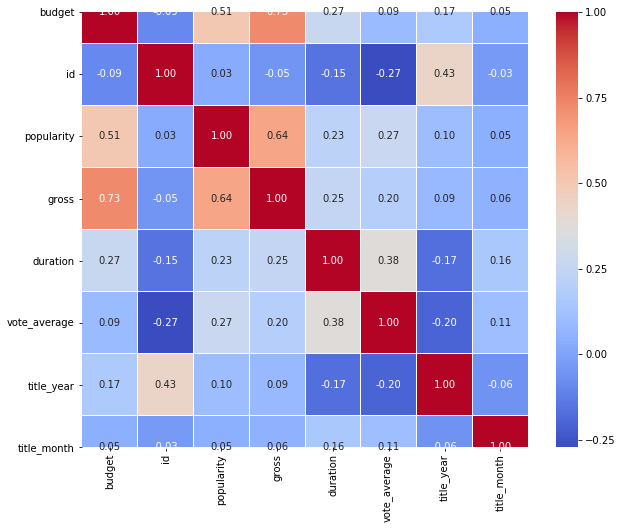

In [7]:
#dropping irel features 2 
pretreated_data.drop(['num_voted_users'], axis=1, inplace=True)
pretreated_data.drop(['homepage'], axis=1, inplace=True)
#correlation matrix with numerical values 
plt.figure(figsize = (10,8))
g = sns.heatmap(pretreated_data[list(pretreated_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x576 with 0 Axes>

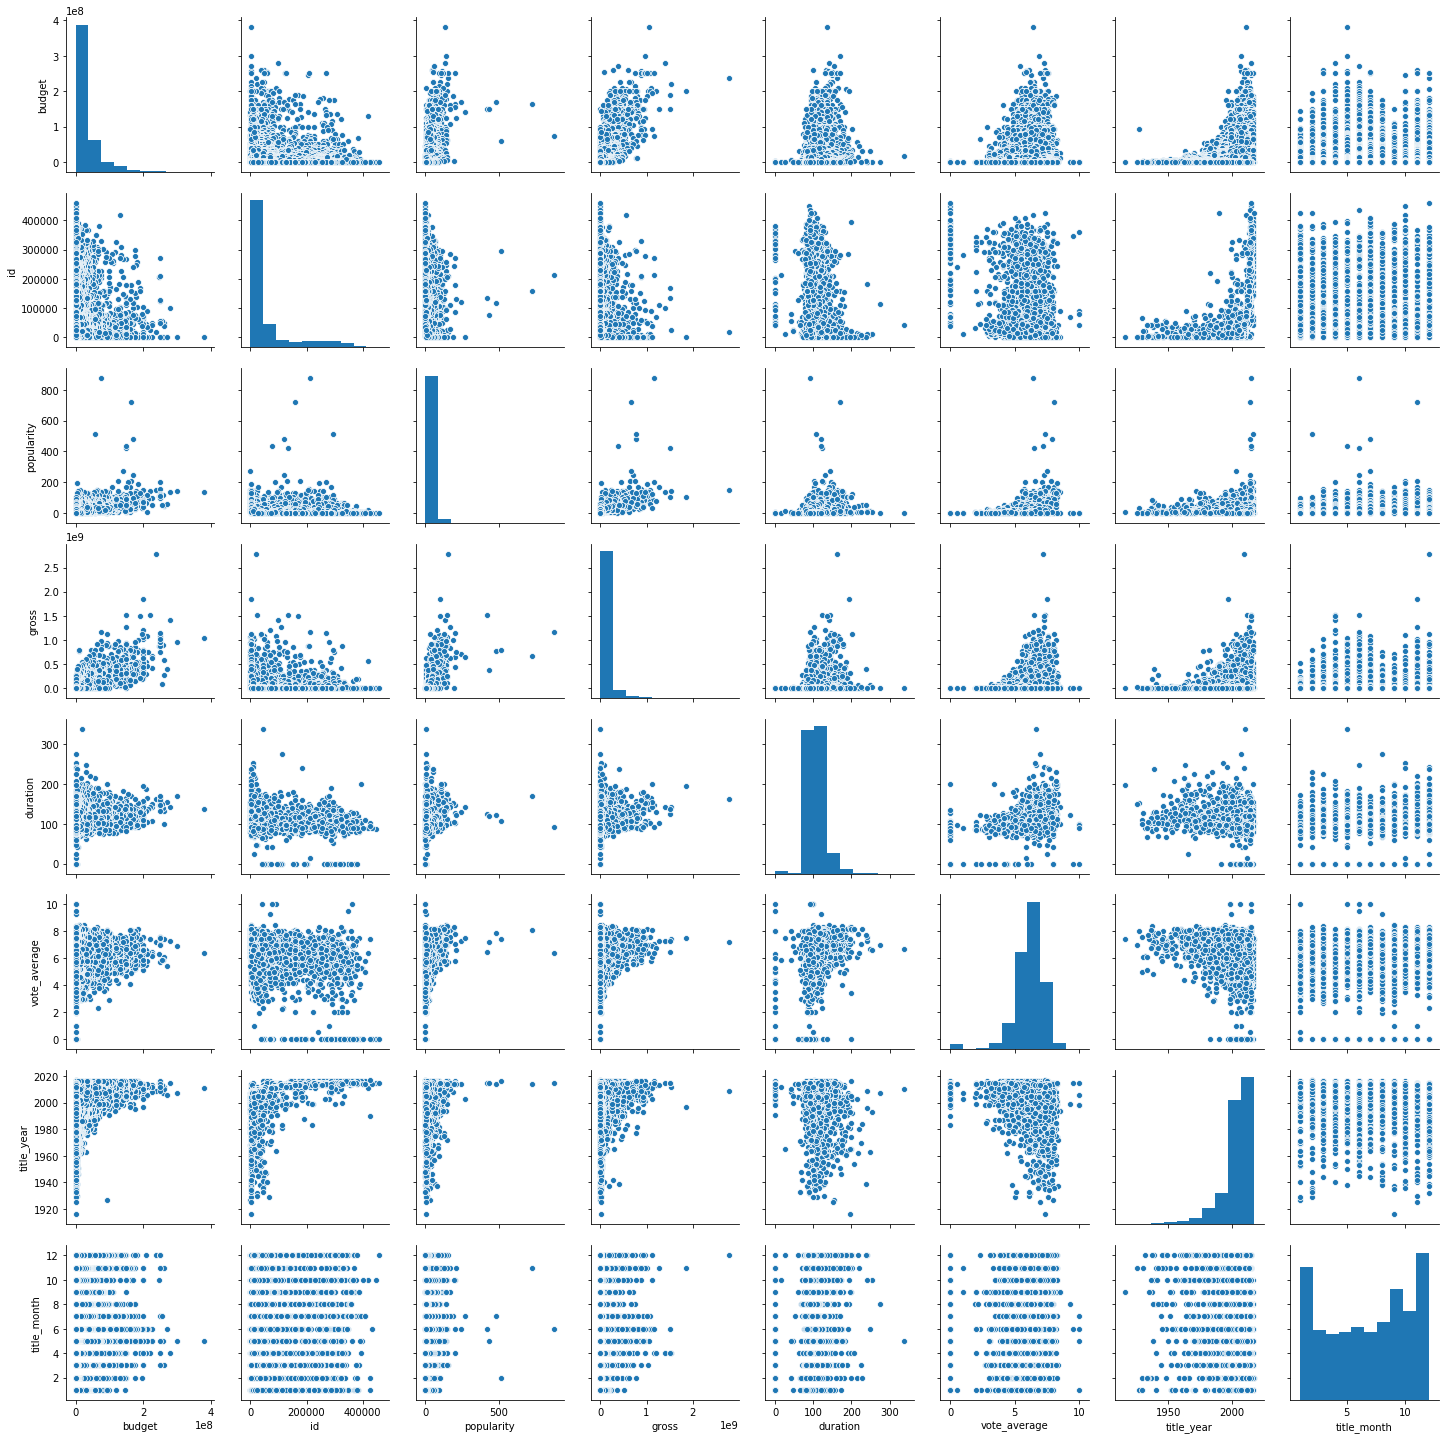

In [8]:
# pair plot to visualize data
plt.figure(figsize = (10,8))
g = sns.pairplot(pretreated_data,palette="bright")

In [9]:
#title year and vote average + duration cleaup 
pretreated_data = pretreated_data[pretreated_data['vote_average'] != 0]
pretreated_data = pretreated_data[pretreated_data['duration'] != 0]
pretreated_data.columns
data= pretreated_data.copy()

Let's convert all the appropriate fields into 1's and 0's for classification 

In [10]:
#convert budget into 1's and 0's for budget: 
import statistics
sd = statistics.stdev(data.budget)
mean = data.budget.mean()
max = data.budget.max()
min = data.budget.min()

#these are hard coded amount of fields and values we can change this accordingly 
#these are def arbitrarly set into 
data['extremelylow'] = data['budget'].map(lambda s: 1 if s < 5000000 else 0)
data['verylow'] = data['budget'].map(lambda s: 1 if 5000000 <= s < 10000000 else 0)
data['low'] = data['budget'].map(lambda s: 1 if 10000000 <= s < mean else 0)
data['avg'] = data['budget'].map(lambda s: 1 if  mean <= s < mean+sd  else 0)
data['high'] = data['budget'].map(lambda s: 1 if mean+sd <= s < 100000000 else 0)
data['veryhigh'] = data['budget'].map(lambda s: 1 if 100000000 < s < 150000000 else 0)
data['blockbusterhigh'] = data['budget'].map(lambda s: 1 if s >= 150000000 else 0)

In [11]:
data.head()

,budget,genres,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,...,companies_1,companies_2,companies_3,extremelylow,verylow,low,avg,high,veryhigh,blockbusterhigh
0,237000000,Action|Adventure|Fantasy|Science Fiction,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Ingenious Film Partners,Twentieth Century Fox Film Corporation,Dune Entertainment,0,0,0,0,0,0,1
1,300000000,Adventure|Fantasy|Action,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Walt Disney Pictures,Jerry Bruckheimer Films,Second Mate Productions,0,0,0,0,0,0,1
2,245000000,Action|Adventure|Crime,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",...,Columbia Pictures,Danjaq,B24,0,0,0,0,0,0,1
3,250000000,Action|Crime|Drama|Thriller,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Legendary Pictures,Warner Bros.,DC Entertainment,0,0,0,0,0,0,1
4,260000000,Action|Adventure|Science Fiction,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Walt Disney Pictures,NaN,NaN,0,0,0,0,0,0,1


In [12]:
data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration',
       'spoken_languages', 'status', 'tagline', 'movie_title', 'vote_average',
       'title_year', 'title_month', 'country', 'director_name', 'actor_1_name',
       'actor_2_name', 'actor_3_name', 'companies_1', 'companies_2',
       'companies_3', 'extremelylow', 'verylow', 'low', 'avg', 'high',
       'veryhigh', 'blockbusterhigh'],
      dtype='object')

In [13]:
#convert month to season 
data['Spring'] = data['title_month'].map(lambda s: 1 if 1 <= s <= 4 else 0)
data['Summer'] = data['title_month'].map(lambda s: 1 if 5 <= s <= 7 else 0)
data['Fall'] = data['title_month'].map(lambda s: 1 if 8 <= s <= 9 else 0)
data['Winter'] = data['title_month'].map(lambda s: 1 if 10 <= s <= 12 else 0) 

In [14]:
#duration 
data = data[np.isfinite(data['duration'])]
data['Lessthan90'] = data['duration'].map(lambda s: 1 if s < 90 else 0)
data['90-120'] = data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
data['120-150'] = data['duration'].map(lambda s: 1 if 120 <= s < 150  else 0)
data['Morethan150'] = data['duration'].map(lambda s: 1 if s >= 150  else 0)
data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration',
       'spoken_languages', 'status', 'tagline', 'movie_title', 'vote_average',
       'title_year', 'title_month', 'country', 'director_name', 'actor_1_name',
       'actor_2_name', 'actor_3_name', 'companies_1', 'companies_2',
       'companies_3', 'extremelylow', 'verylow', 'low', 'avg', 'high',
       'veryhigh', 'blockbusterhigh', 'Spring', 'Summer', 'Fall', 'Winter',
       'Lessthan90', '90-120', '120-150', 'Morethan150'],
      dtype='object')

In [15]:
#genre
# impact on cross-validation scores:
# popularity success -> +3
# vote success -> +2.5-3
# commercial success -> -4.5-5
data['genres'].head()
genresUnflattened = list(map(lambda x: x.split('|'), data['genres']))
genres = set([item for subl in genresUnflattened for item in subl])
genres.remove('')
for genre in genres:
    data[genre] = data['genres'].map(lambda s: 1 if genre in str(s) else 0)
# data1.head()
data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration',
       'spoken_languages', 'status', 'tagline', 'movie_title', 'vote_average',
       'title_year', 'title_month', 'country', 'director_name', 'actor_1_name',
       'actor_2_name', 'actor_3_name', 'companies_1', 'companies_2',
       'companies_3', 'extremelylow', 'verylow', 'low', 'avg', 'high',
       'veryhigh', 'blockbusterhigh', 'Spring', 'Summer', 'Fall', 'Winter',
       'Lessthan90', '90-120', '120-150', 'Morethan150', 'History',
       'Documentary', 'TV Movie', 'Horror', 'Adventure', 'Family', 'Thriller',
       'Fantasy', 'Action', 'Foreign', 'Music', 'Mystery', 'Romance', 'Comedy',
       'Animation', 'Drama', 'Science Fiction', 'Crime', 'Western', 'War'],
      dtype='object')

We also need to define our measurement for success

In [16]:
#Actually these are the 3 success in a nutshell
popularity_data = data.copy()
popularity_data['Popularity Success'] = popularity_data['popularity'].map(lambda s :1  if s >= popularity_data['popularity'].mean() else 0) 
popularity_data['Vote Success'] = popularity_data['vote_average'].map(lambda s :1  if s >= popularity_data['vote_average'].mean() else 0)
popularity_data['Commercial Success'] = popularity_data['gross'] > popularity_data['budget']
popularity_data['Commercial Success'] = popularity_data['Commercial Success'].astype(int)


#metrics for true success
# svm accuracy scores: conditionAll ~= 79% > condition1orMore ~= 75% > condition2orMore ~= 55%
condition2orMore = (((popularity_data['Popularity Success'] == 1) & (popularity_data['Vote Success'] == 1)) | 
             ((popularity_data['Popularity Success'] == 1) & (popularity_data['Commercial Success'] == 1)) | 
             ((popularity_data['Commercial Success'] == 1) & (popularity_data['Vote Success'] == 1)))

condition1orMore = ((popularity_data['Popularity Success'] == 1) | 
                 (popularity_data['Vote Success'] == 1) | 
                 (popularity_data['Commercial Success'] == 1))

conditionAll = ((popularity_data['Popularity Success'] == 1) & 
                 (popularity_data['Vote Success'] == 1) & 
                 (popularity_data['Commercial Success'] == 1))

popularity_data['True Success'] = np.where(conditionAll, 1, 0)


In [17]:
popularity_data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration',
       'spoken_languages', 'status', 'tagline', 'movie_title', 'vote_average',
       'title_year', 'title_month', 'country', 'director_name', 'actor_1_name',
       'actor_2_name', 'actor_3_name', 'companies_1', 'companies_2',
       'companies_3', 'extremelylow', 'verylow', 'low', 'avg', 'high',
       'veryhigh', 'blockbusterhigh', 'Spring', 'Summer', 'Fall', 'Winter',
       'Lessthan90', '90-120', '120-150', 'Morethan150', 'History',
       'Documentary', 'TV Movie', 'Horror', 'Adventure', 'Family', 'Thriller',
       'Fantasy', 'Action', 'Foreign', 'Music', 'Mystery', 'Romance', 'Comedy',
       'Animation', 'Drama', 'Science Fiction', 'Crime', 'Western', 'War',
       'Popularity Success', 'Vote Success', 'Commercial Success',
       'True Success'],
      dtype='object')

Let's do some visualizations on the features x Success before we drop all the useless fields 

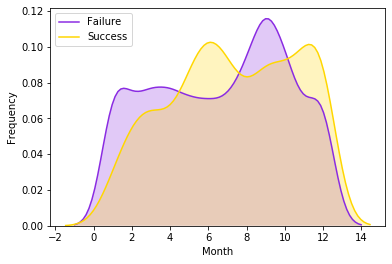

In [18]:
#title_month
g = sns.kdeplot(popularity_data.title_month[(popularity_data["True Success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(popularity_data.title_month[(popularity_data["True Success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Month")
g.set_ylabel("Frequency")
g = g.legend(["Failure","Success"])

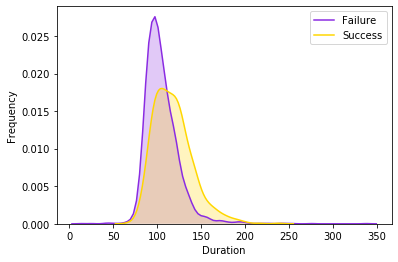

In [19]:
#duration 
g = sns.kdeplot(popularity_data.duration[(popularity_data["True Success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(popularity_data.duration[(popularity_data["True Success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Duration")
g.set_ylabel("Frequency")
g = g.legend(["Failure","Success"])

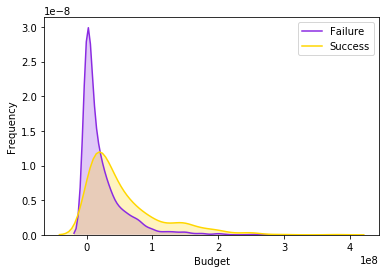

In [20]:
#duration 
g = sns.kdeplot(popularity_data.budget[(popularity_data["True Success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(popularity_data.budget[(popularity_data["True Success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Budget")
g.set_ylabel("Frequency")
g = g.legend(["Failure","Success"])

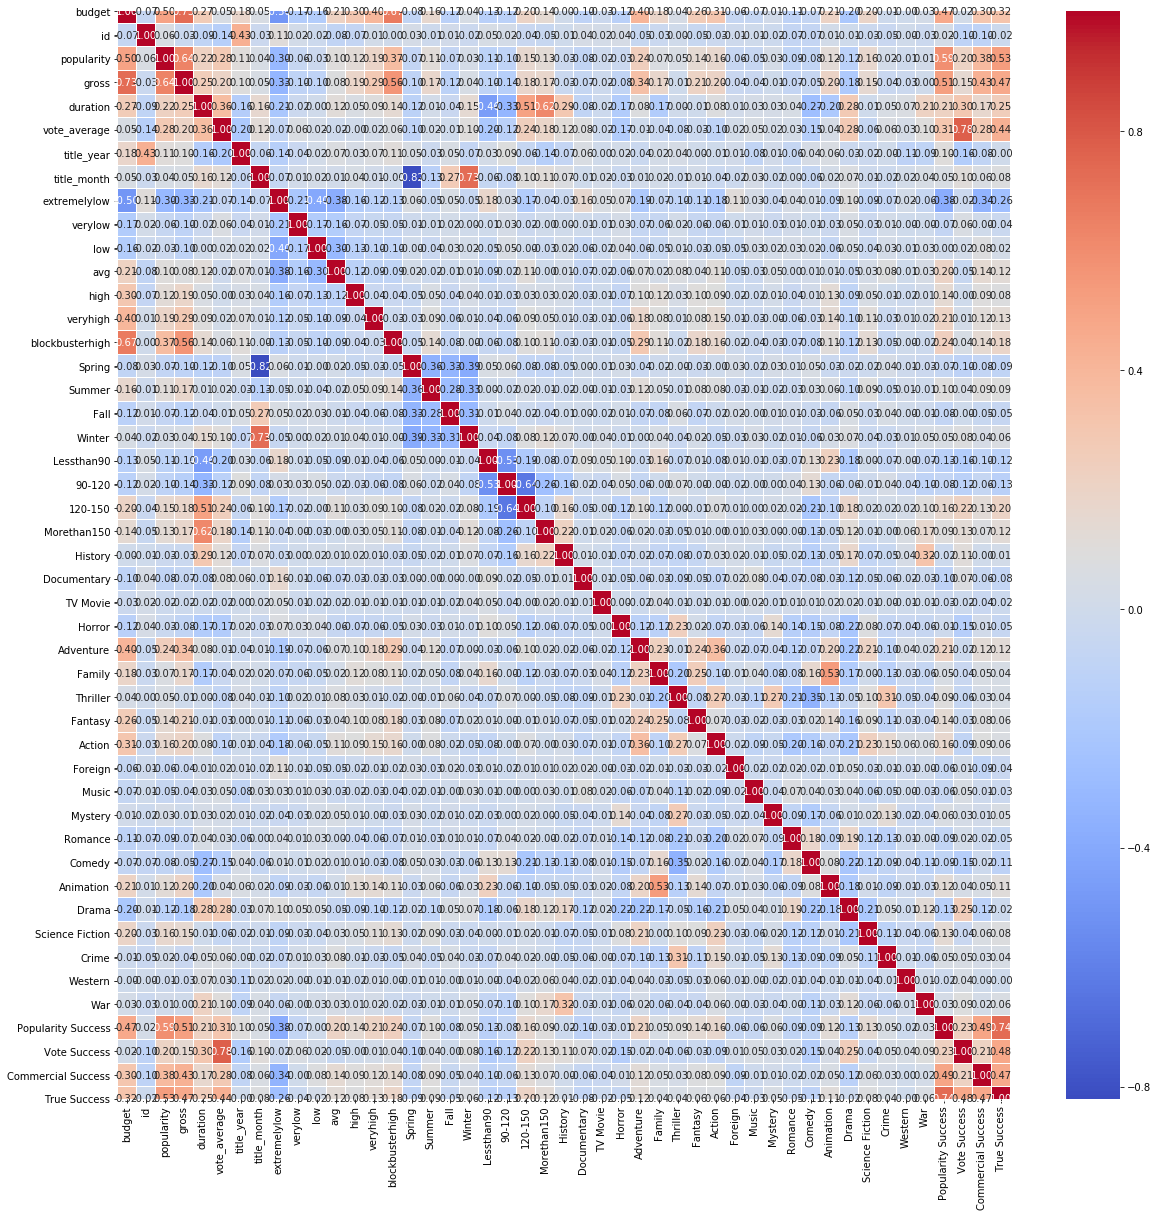

In [21]:
#correlation matrix with numerical values 
plt.figure(figsize = (20,20))
g = sns.heatmap(popularity_data[list(popularity_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

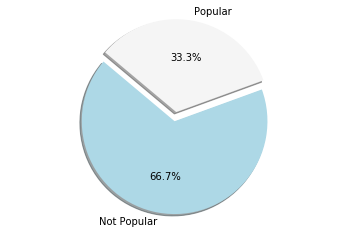

In [22]:
# Data to plot
labels =["Not Popular","Popular"]
sizes = popularity_data['Popularity Success'].value_counts(sort = False)
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

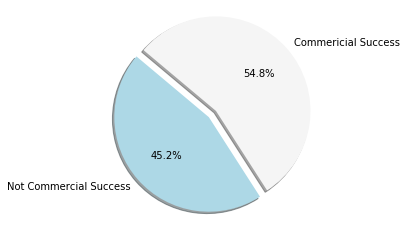

In [23]:
# Data to plot
labels =["Not Commercial Success","Commericial Success"]
sizes = popularity_data['Commercial Success'].value_counts(sort = False)
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

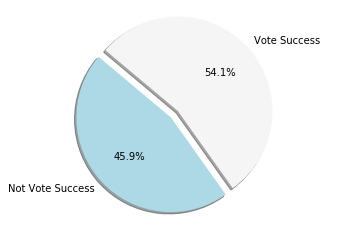

In [24]:
# Data to plot
labels =["Not Vote Success","Vote Success"]
sizes = popularity_data['Vote Success'].value_counts(sort = False)
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

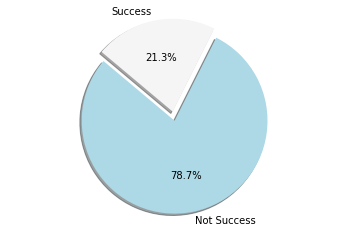

In [25]:
# Data to plot
labels =["Not Success","Success"]
sizes = popularity_data['True Success'].value_counts(sort = False)
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

Time to drop the fields 

In [26]:
#title_year IS dropped atm for testing of months ; duration is dropped
popularity_data.drop(['id','budget','original_title','overview','spoken_languages','production_companies','production_countries','release_date','status',
          'tagline','movie_title','vote_average','language','director_name','actor_1_name','actor_2_name','actor_3_name',
          'companies_1','companies_2','companies_3','country','genres','plot_keywords','popularity','gross', 'title_month', 'duration', 'title_year'], axis=1, inplace=True)
popularity_data.columns

Index(['extremelylow', 'verylow', 'low', 'avg', 'high', 'veryhigh',
       'blockbusterhigh', 'Spring', 'Summer', 'Fall', 'Winter', 'Lessthan90',
       '90-120', '120-150', 'Morethan150', 'History', 'Documentary',
       'TV Movie', 'Horror', 'Adventure', 'Family', 'Thriller', 'Fantasy',
       'Action', 'Foreign', 'Music', 'Mystery', 'Romance', 'Comedy',
       'Animation', 'Drama', 'Science Fiction', 'Crime', 'Western', 'War',
       'Popularity Success', 'Vote Success', 'Commercial Success',
       'True Success'],
      dtype='object')

In [27]:
# #correlation matrix with numerical values after drop: so these looking at all feature that will be tested 
# plt.figure(figsize = (20,20))
# g = sns.heatmap(popularity_data[list(popularity_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

In [28]:
#when running aggregate/success drop the other success metics 
popularity_data.drop(['Popularity Success', 'Vote Success', 'Commercial Success'], axis=1, inplace=True)

In [29]:
popularity_data

,extremelylow,verylow,low,avg,high,veryhigh,blockbusterhigh,Spring,Summer,Fall,...,Mystery,Romance,Comedy,Animation,Drama,Science Fiction,Crime,Western,War,True Success
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4799,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4800,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
4801,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Decision tree to determine success:

In [30]:
from sklearn import metrics

In [31]:

popularity_data['is_train'] = np.random.uniform(0, 1, len(popularity_data)) <= .75


In [32]:
train, test = popularity_data[popularity_data['is_train']==True], popularity_data[popularity_data['is_train']==False]
train.drop(['is_train'], axis=1, inplace=True)
test.drop(['is_train'], axis=1, inplace=True)

# Let's test against different Success Metrics 

# train["Popularity Success"] = train["Popularity Success"].astype(int)

# Y_train = train["Popularity Success"]
# X_train = train.drop(labels = ["Popularity Success"],axis = 1)

# Y_test = test["Popularity Success"]
# X_test = test.drop(labels = ["Popularity Success"],axis = 1)

# train["Vote Success"] = train["Vote Success"].astype(int)

# Y_train = train["Vote Success"]
# X_train = train.drop(labels = ["Vote Success"],axis = 1)

# Y_test = test["Vote Success"]
# X_test = test.drop(labels = ["Vote Success"],axis = 1)

# train["Commercial Success"] = train["Commercial Success"].astype(int)

# Y_train = train["Commercial Success"]
# X_train = train.drop(labels = ["Commercial Success"],axis = 1)

# Y_test = test["Commercial Success"]
# X_test = test.drop(labels = ["Commercial Success"],axis = 1)

# train["True Success"] = train["True Success"].astype(int)

Y_train = train["True Success"]
X_train = train.drop(labels = ["True Success"],axis = 1)

Y_test = test["True Success"]
X_test = test.drop(labels = ["True Success"],axis = 1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
print(len(train))


3564


In [34]:
print(len(test))

1152


In [35]:
# here's the decision tree 
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=7)
dtc.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [36]:
from sklearn.model_selection import  cross_val_score
# Decision Tree - Cross Validation Score 
cross_val_dtc = cross_val_score(dtc, X_train, Y_train, cv=10)
cross_val_dtc.mean()

0.7323916222605517

In [37]:
result = dtc.predict_proba(X_test)[:]
test_result = np.asarray(Y_test)

dtcResults = pd.DataFrame(result[:,1])
dtcResults['Predict'] = dtcResults[0].map(lambda s: 1 if s >= 0.5  else 0)
dtcResults['testAnswer'] = pd.DataFrame(test_result)

dtcResults['Correct'] = np.where((dtcResults['Predict'] == dtcResults['testAnswer']), 1, 0)
dtcResults.head()

,0,Predict,testAnswer,Correct
0,1.000000,1,1,1
1,0.724138,1,1,1
2,0.208861,0,0,1
3,0.500000,1,1,1
4,0.724138,1,1,1


In [38]:
from sklearn.metrics import confusion_matrix
dtc_confusion = confusion_matrix(dtcResults['Predict'], dtcResults['testAnswer'])
print(dtc_confusion) #Predict 1 and Test 0; Predict 0 and Test 1 #Predict 1 and Test 0; Predict 0 and Test 0

[[855 165]
 [ 71  61]]


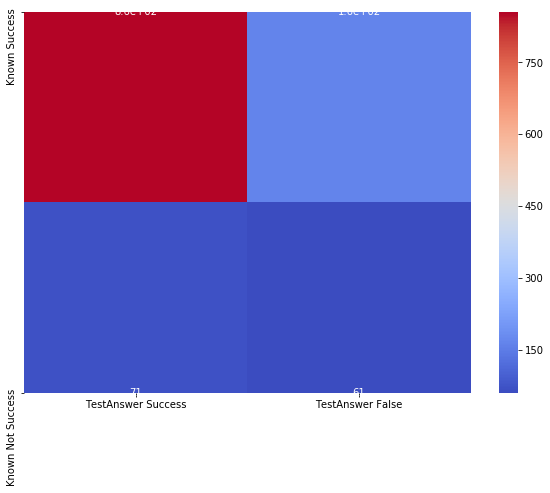

In [39]:
con_dec = pd.DataFrame(dtc_confusion, index = [i for i in ["Known Success", "Known Not Success"]],
columns = [i for i in ["TestAnswer Success", "TestAnswer False"]])
plt.figure(figsize = (10,7))
plt.xlabel("Predict")
plt.ylabel("TestAnswer")
sns.heatmap(con_dec, cmap = "coolwarm", annot=True)

In [40]:
#test Data set - score 
dtcResults['Correct'].mean()


0.7951388888888888

In [41]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus# Export as dot file
# dot_data = StringIO()
# export_graphviz(dtc, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

Random forest model:

In [42]:
#heres a random forest tree model 
from sklearn.ensemble import RandomForestClassifier

randofor = RandomForestClassifier(max_depth=7)
randofor.fit(X_train, Y_train)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
#Random Forest - cross validation score 
cross_val_randofor =  cross_val_score(randofor, X_train, Y_train, cv=10)
cross_val_randofor.mean()

0.741931933083409

In [44]:
result = randofor.predict_proba(X_test)[:]
randoforResults = pd.DataFrame(result[:,1])
randoforResults['Predict'] = randoforResults[0].map(lambda s: 1 if s >= 0.5  else 0)
randoforResults['testAnswer'] = pd.DataFrame(test_result)

randoforResults['Correct'] = np.where((randoforResults['Predict'] == randoforResults['testAnswer'])
                     , 1, 0)
randoforResults.head()

,0,Predict,testAnswer,Correct
0,0.725478,1,1,1
1,0.631120,1,1,1
2,0.373961,0,0,1
3,0.546983,1,1,1
4,0.600740,1,1,1


In [45]:
from sklearn.metrics import confusion_matrix
randofor_confusion = confusion_matrix(randoforResults['Predict'], randoforResults['testAnswer'])
print(randofor_confusion) #Predict 1 and Test 0; Predict 0 and Test 1 #Predict 1 and Test 0; Predict 0 and Test 0

[[902 185]
 [ 24  41]]


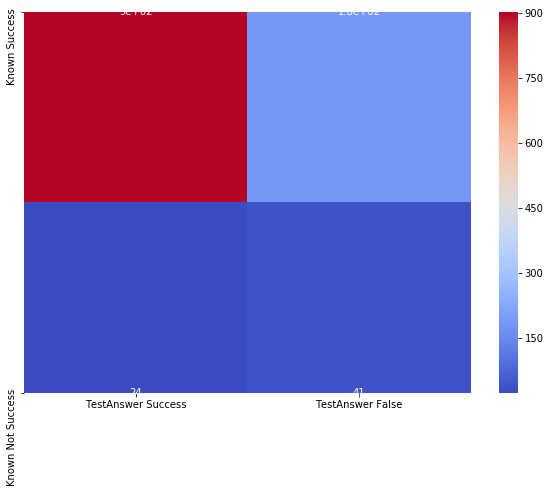

In [46]:
con_dec = pd.DataFrame(randofor_confusion, index = [i for i in ["Known Success", "Known Not Success"]],
columns = [i for i in ["TestAnswer Success", "TestAnswer False"]])
plt.figure(figsize = (10,7))
plt.xlabel("Predict")
plt.ylabel("TestAnswer")
sns.heatmap(con_dec, cmap = "coolwarm", annot=True)

In [47]:
randoforResults['Correct'].mean()


0.8185763888888888

In [48]:
#uses sklearn.metrics to find accuracy score here 
# prediction = randofor.predict(X_test)
# print(metrics.accuracy_score(prediction, Y_test))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


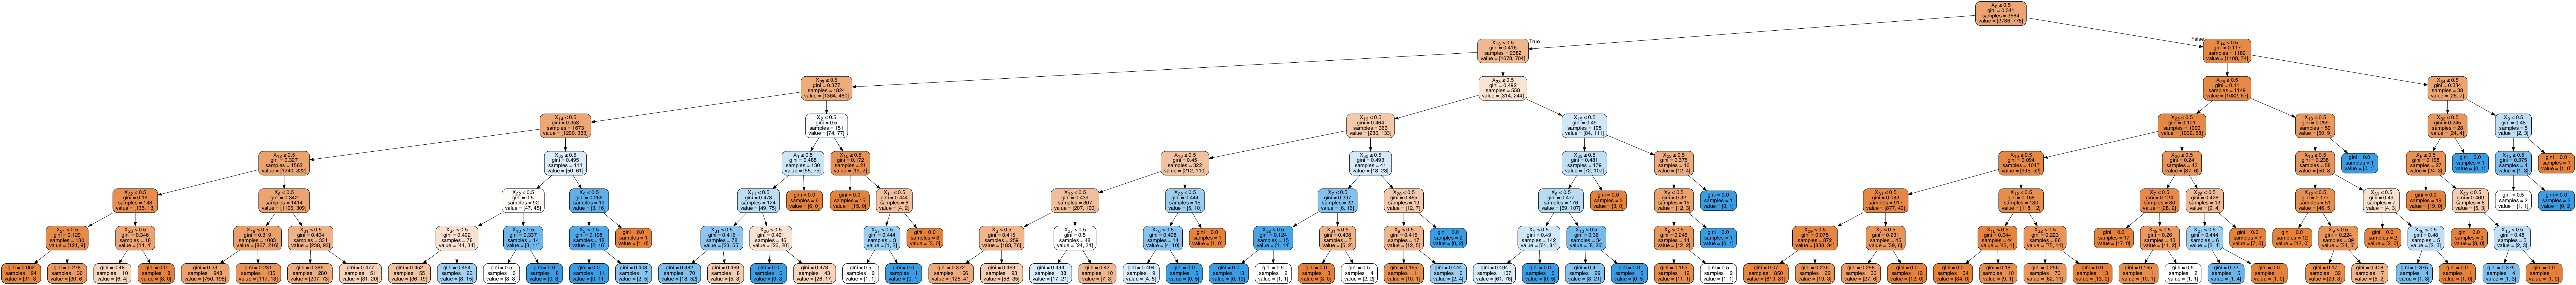

In [49]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus# Export as dot file
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

K-Nearest Neighbors:

In [50]:
#k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100) #can play around with this (neighbors)
knn.fit(X_train, Y_train)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [51]:
cross_val_knn = cross_val_score(knn, X_train, Y_train, cv=10) 
cross_val_knn.mean()

0.7713452758853185

In [52]:
result = knn.predict_proba(X_test)[:]
knnResults = pd.DataFrame(result[:,1])
knnResults['Predict'] = knnResults[0].map(lambda s: 1 if s >= 0.5  else 0)
knnResults['testAnswer'] = pd.DataFrame(test_result)

knnResults['Correct'] = np.where((knnResults['Predict'] == knnResults['testAnswer'])
                     , 1, 0)
knnResults.head()

,0,Predict,testAnswer,Correct
0,0.62,1,1,1
1,0.50,1,1,1
2,0.31,0,0,1
3,0.50,1,1,1
4,0.60,1,1,1


In [53]:
from sklearn.metrics import confusion_matrix
knn_confusion = confusion_matrix(knnResults['Predict'], knnResults['testAnswer'])
print(knn_confusion) #Predict 1 and Test 0; Predict 0 and Test 1 #Predict 1 and Test 0; Predict 0 and Test 0

[[919 190]
 [  7  36]]


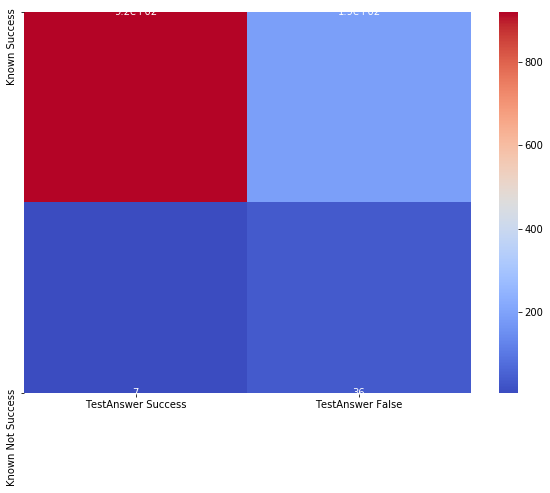

In [54]:
con_dec = pd.DataFrame(knn_confusion, index = [i for i in ["Known Success", "Known Not Success"]],
columns = [i for i in ["TestAnswer Success", "TestAnswer False"]])
plt.figure(figsize = (10,7))
plt.xlabel("Predict")
plt.ylabel("TestAnswer")
sns.heatmap(con_dec, cmap = "coolwarm", annot=True)

In [55]:
knnResults['Correct'].mean()


0.8289930555555556

SVM:

In [56]:
from sklearn import svm
svm = svm.SVC(kernel='linear', gamma='scale', probability=True)
svm.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [57]:
cross_val_svm = cross_val_score(svm, X_train, Y_train, cv=10) 
cross_val_svm.mean()

0.747533387148181

In [58]:
#trying to get svm to work??
result = svm.predict_proba(X_test)
svmResults = pd.DataFrame(result[:,1])
svmResults['Predict'] = svmResults[0].map(lambda s: 1 if s >= 0.5  else 0)
svmResults['testAnswer'] = pd.DataFrame(test_result)
svmResults['Correct'] = np.where((svmResults['Predict'] == svmResults['testAnswer'])
                     , 1, 0)
svmResults


,0,Predict,testAnswer,Correct
0,0.565456,1,1,1
1,0.565417,1,1,1
2,0.565405,1,0,0
3,0.565471,1,1,1
4,0.565448,1,1,1
...,...,...,...,...
1147,0.200948,0,0,1
1148,0.201028,0,0,1
1149,0.201025,0,0,1
1150,0.201004,0,0,1


In [59]:
from sklearn.metrics import confusion_matrix
svm_confusion = confusion_matrix(svmResults['Predict'], svmResults['testAnswer'])
print(svm_confusion) #Predict 1 and Test 0; Predict 0 and Test 1 #Predict 1 and Test 0; Predict 0 and Test 0

[[905 191]
 [ 21  35]]


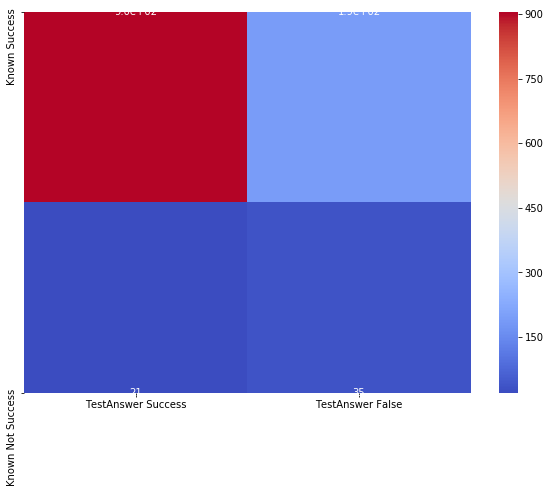

In [60]:
con_dec = pd.DataFrame(svm_confusion, index = [i for i in ["Known Success", "Known Not Success"]],
columns = [i for i in ["TestAnswer Success", "TestAnswer False"]])
plt.figure(figsize = (10,7))
plt.xlabel("Predict")
plt.ylabel("TestAnswer")
sns.heatmap(con_dec, cmap = "coolwarm", annot=True)

In [61]:
svmResults['Correct'].mean()

0.8159722222222222

Decision Tree:

In [62]:
#decision tree 
dtcFeatures = pd.DataFrame(dtc.feature_importances_)
dtcFeatures["name"] = list(X_train) 
dtcFeatures.sort_values(by=0, ascending=False).head()

,0,name
0,0.294202,extremelylow
13,0.105070,120-150
14,0.089085,Morethan150
29,0.076526,Animation
23,0.040701,Action


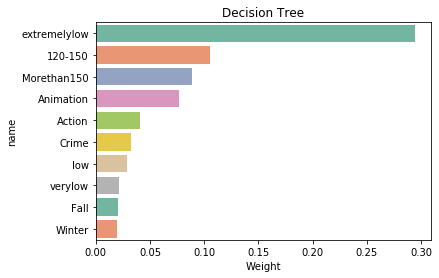

In [63]:
g = sns.barplot(0,"name",data = dtcFeatures.sort_values(by=0, ascending=False)[0:10], palette="Set2",orient = "h")
g.set_xlabel("Weight")
g = g.set_title("Decision Tree")

Random Forest:

In [64]:
#random forest 
randoforFeatures = pd.DataFrame(randofor.feature_importances_)
randoforFeatures["name"] = list(X_train) 
randoforFeatures.sort_values(by=0, ascending=False).head()

,0,name
0,0.199752,extremelylow
13,0.092016,120-150
29,0.071130,Animation
6,0.052274,blockbusterhigh
11,0.050243,Lessthan90


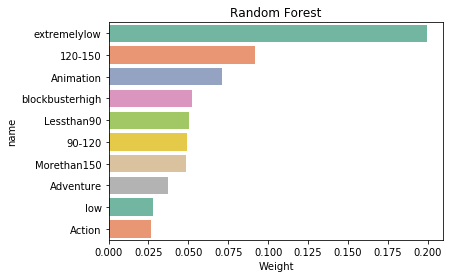

In [65]:
g = sns.barplot(0,"name",data = randoforFeatures.sort_values(by=0, ascending=False)[0:10], palette="Set2",orient = "h")
g.set_xlabel("Weight")
g = g.set_title("Random Forest")

In [66]:
#also really low budget and a bunch of genres 

In [67]:
#knn vis 
# from mlxtend.plotting import plot_decision_regions
# plot_decision_regions(X_train.values, Y_train.values, clf=knn, legend=2)
# plt.show()



In [68]:
#svm vis
#https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py??
# svm.support_vectors_


In [69]:
# plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=Y_train, s=50, cmap='autumn')